In [8]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import datashader as ds
from colorcet import fire


In [9]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_NC_KEY")

In [10]:
# Import the CSVs to Pandas DataFrames
mcoutput_path = Path("../Data/mc_output.csv")
mc_data = pd.read_csv(mcoutput_path)
mc_data

,Unnamed: 0,Unnamed: 1,1 Year Avg Return,3 Year Avg Return,5 Year Avg Return,lat,lng,population,firstzip
0,Cullman,AL,0.029739,0.032062,0.033077,34.1777,-86.8407,19920.0,35058
1,Gallup,NM,0.003838,0.004258,0.004456,35.5183,-108.7423,22917.0,87301
2,Niles,MI,0.023460,0.025404,0.026323,41.8346,-86.2473,11149.0,49120
3,Dodge City,KS,0.018783,0.020161,0.020854,37.7610,-100.0183,27080.0,67801
4,Coffeyville,KS,-0.002473,-0.001819,-0.001617,37.0518,-95.6180,9827.0,67337
...,...,...,...,...,...,...,...,...,...
882,Bloomington,IL,0.014703,0.015560,0.016005,40.4757,-88.9703,133846.0,61701
883,Manitowoc,WI,0.025086,0.026686,0.027520,44.0991,-87.6811,44770.0,54220
884,Fergus Falls,MN,0.021240,0.022024,0.022594,46.2853,-96.0760,12683.0,56537
885,Lewisburg,PA,0.013600,0.014163,0.014151,40.9642,-76.8901,5708.0,17837


In [4]:
# create dataframe
mc_df = pd.DataFrame(data=mc_data)

In [41]:
# simple mapbox visual ofr 5 year average returns

px.set_mapbox_access_token(mapbox_token)

mc_map = px.scatter_mapbox(
    mc_df,
    lat="lat",
    lon="lng",
    size="population",
    color="5 Year Avg Return",
    hover_name="Unnamed: 0",
    zoom=3,
    mapbox_style='light',
    width=900,
    height=700,
    color_continuous_scale=px.colors.diverging.Portland)

mc_map.update_layout(title='5 year avg return per city')




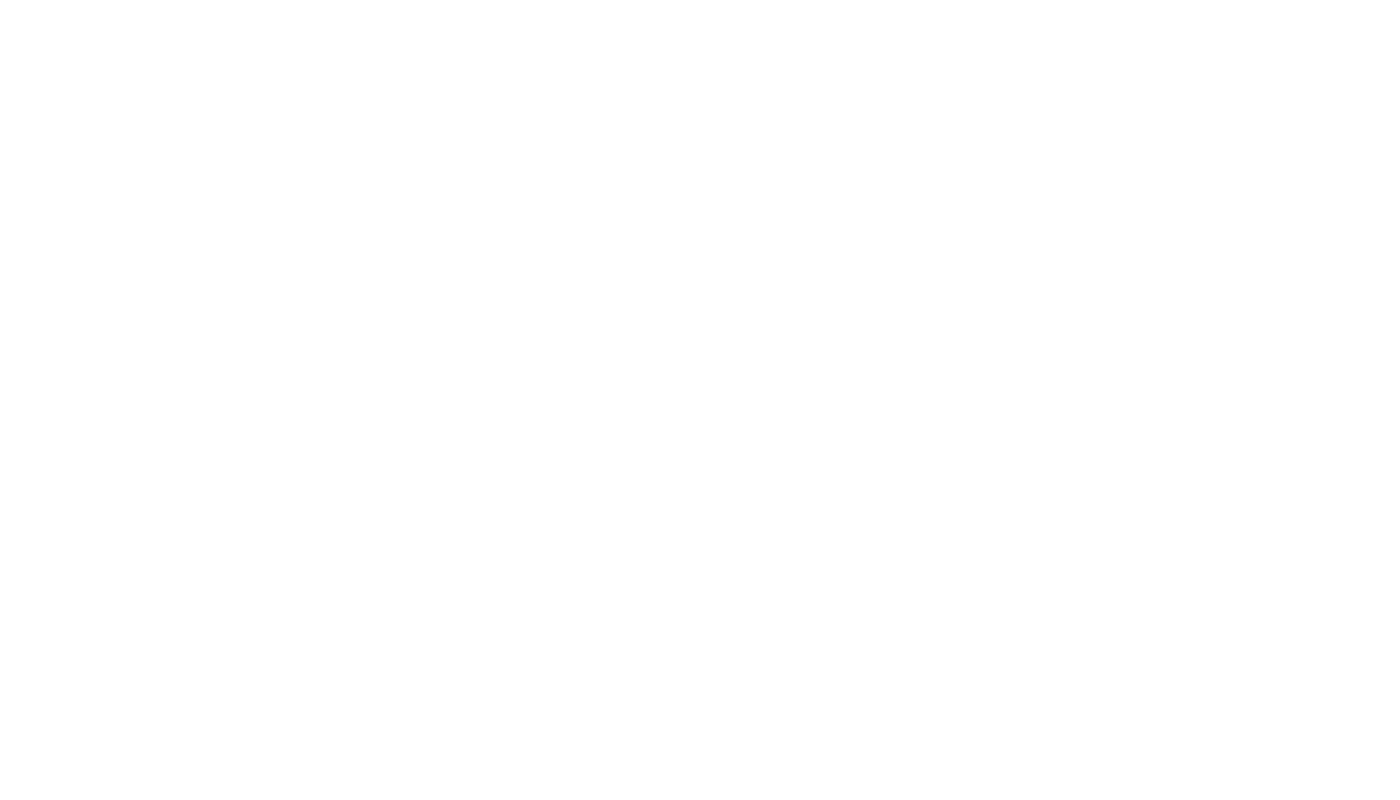

In [13]:


cvs = ds.Canvas(plot_width=1000, plot_height=1000)
stations = mc_df.query("lng < -40").query("lng > -100").query("lat < 50").query("lat > 30")
agg = cvs.points(stations, x='lng', y='lat')

# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
coords_lat, coords_lon = agg.coords['lat'].values, agg.coords['lng'].values

# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]


from colorcet import fire
import datashader.transfer_functions as tf
img = tf.shade(agg, cmap=fire, how='log')[::-1].to_pil()
img = img.resize((1400, 800))

#from matplotlib.cm import hot
#import datashader.transfer_functions as tf
#img=(tf.shade(agg, cmap = hot, how='log'))[::-1].to_pil()


# Trick to create rapidly a figure with mapbox axes
fig = px.scatter_mapbox(mc_df, 
                        lat='lat',
                        lon='lng',
                        size="population",
                        hover_name="Unnamed: 0",
                        zoom=3,)

# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",                  
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()